<a href="https://colab.research.google.com/github/Jevaan21/intrusion-detection-dl/blob/main/intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import tensorflow as tf


In [3]:
# Download NSL-KDD dataset
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt -O KDDTrain+.txt


--2025-07-15 02:51:53--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘KDDTrain+.txt’

KDDTrain+.txt       100%[===================>]  18.22M  --.-KB/s    in 0.1s    

2025-07-15 02:51:54 (130 MB/s) - ‘KDDTrain+.txt’ saved [19109424/19109424]



In [4]:
# Define column names
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty"
]

In [5]:
# Load and clean
df = pd.read_csv("KDDTrain+.txt", names=col_names)
df.drop(columns=['difficulty'], inplace=True)

Preprocess Data

In [7]:
# Binary label: 0 = normal, 1 = attack
df['label'] = df['label'].apply(lambda x: 0 if 'normal' in str(x).lower() else 1)

In [8]:
# Encode categorical columns
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [9]:
# Split and scale
X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9606 - loss: 0.1082 - val_accuracy: 0.9903 - val_loss: 0.0363
Epoch 2/5
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9909 - loss: 0.0269 - val_accuracy: 0.9905 - val_loss: 0.0257
Epoch 3/5
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9925 - loss: 0.0209 - val_accuracy: 0.9917 - val_loss: 0.0317
Epoch 4/5
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9930 - loss: 0.0208 - val_accuracy: 0.9911 - val_loss: 0.0266
Epoch 5/5
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9936 - loss: 0.0183 - val_accuracy: 0.9930 - val_loss: 0.0257


Evaluate and plot

In [12]:
# Predict
y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)


788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


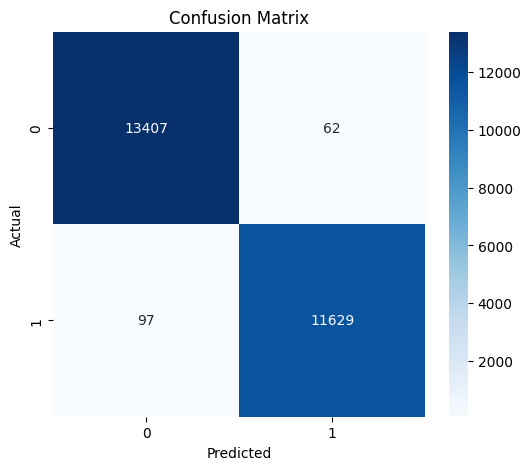

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

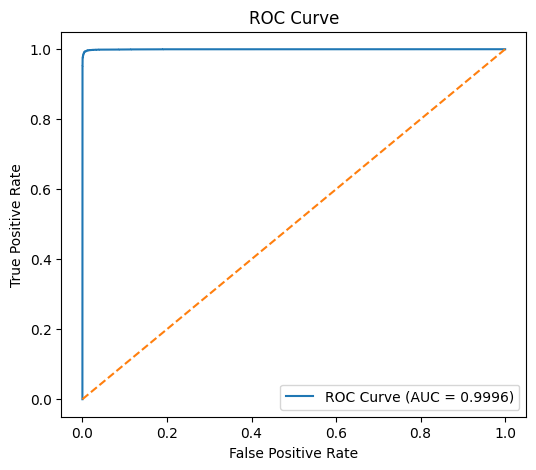

In [15]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()